# Product Range Analysis

Our e-commerce company was recently bought by new investors. With this big change, we've started a project to look closely at the products we sell. This Product Range Analysis will help us understand how well our products are doing and what our customers like. It's important for us to see where we can do better or try new things. In this report, we will share findings about our products and suggest some ideas for the future.

## Additional Material

* [Presentation](https://drive.google.com/file/d/1KqS8Ucy19FADj6RA3KW28d1CqmZw3n5v/view?usp=sharing)

## Table of Contents

* [Imports](#imports)
* [Reading the Data](#reading)
* [Data Exploration](#explore)
* [Hypothesis Testing](#hypotheses)
* [Conclusion](#conclusion)

## Imports <a class="anchor" id="imports">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

## Reading the Data <a class="anchor" id="reading">

Nothing special here, other than we're already telling pandas to parse the `InvoiceDate` column as a `datetime` object.

In [2]:
try:
    df = pd.read_csv("/datasets/ecommerce_dataset_us.csv", sep="\t", parse_dates=["InvoiceDate"])
except FileNotFoundError:
    df = pd.read_csv("ecommerce_dataset_us.csv", sep="\t", parse_dates=["InvoiceDate"])

## Data Exploration <a class="anchor" id="explore">

Let's take a look at the first few rows:

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0


The first thing that pops out is that pandas read the `CustomerID` column as a `float`, which means only one thing: we have missing values! 😱

Let's see how bad the situation is:

In [4]:
df.isna().sum() / len(df) * 100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
dtype: float64

It's not that bad, I guess. We have two columns with missing values: `Description` is missing 0.27% of the rows, and `CustomerID` is missing in 24.93% of the rows. The `CustomerID` column is missing too many values to just drop all willy-nilly. We'll keep it for now, and see if we can use the data without it.

Now let's check for duplicate data:

In [5]:
num_duplicates = df.duplicated().sum()
print(f"There are {num_duplicates:,} duplicate rows, which is {num_duplicates / len(df):.2%} of the rows.")

There are 5,268 duplicate rows, which is 0.97% of the rows.


At less than one percent of the total number of rows, we can and should get rid of the duplicate rows, as they might skew our analysis. It's important to notice that these rows are duplicated in every column, meaning that a specific purchase (product, quantity, invoice number) was made by the same customer at the same time more than once. This is too much to be considered normal, so we treat those as anomalies.

In [6]:
df.drop_duplicates(inplace=True)

Let's see if what our working days are:

In [7]:
df["InvoiceDate"].dt.dayofweek.value_counts().sort_index()

0     62806
1     94435
2    101064
3     93715
4    103056
5     81565
Name: InvoiceDate, dtype: int64

Well, what do you know, we don't work on Sundays (0 = Monday, 6 = Sunday). Good to know.

Let's take a look at the other columns, starting with `Quantity`:

In [8]:
df["Quantity"].describe()

count    536641.000000
mean          9.620029
std         219.130156
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

Well, what do we have here? The minimum is a negative quantity. Let's look at that more closely:

In [9]:
df.query('Quantity <= 0').sort_values(by="Quantity", ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
141,C536379,D,Discount,-1,2018-11-29 09:41:00,27.50,14527.0
193458,C553533,22770,MIRROR CORNICE,-1,2019-05-15 15:13:00,14.95,17612.0
193136,C553511,BANK CHARGES,Bank Charges,-1,2019-05-15 13:49:00,86.90,NaN
193134,C553510,POST,POSTAGE,-1,2019-05-15 13:46:00,1.00,14342.0
390505,C570553,23048,SET OF 10 LANTERNS FAIRY LIGHT STAR,-1,2019-10-09 11:01:00,4.15,14800.0
...,...,...,...,...,...,...,...
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2018-11-30 14:23:00,0.03,15838.0
225529,556690,23005,printing smudges/thrown away,-9600,2019-06-12 10:37:00,0.00,NaN
225530,556691,23005,printing smudges/thrown away,-9600,2019-06-12 10:37:00,0.00,NaN
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2019-01-16 10:17:00,1.04,12346.0


That's a lot of negatives that don't seem to have rhyme or reason. Maybe those are returns? From the glimpse of the data we have above, other than the two "printing smudges/thrown away" items, all other invoice numbers start with the letter "C". Could "C" mean that the order was returned? Let's check:

In [10]:
np.all(df.loc[df["InvoiceNo"].str.startswith("C"), "Quantity"] < 0)

True

Seems so. Every order with an invoice number that starts with "C" has a negative quantity, which most probably means the order was returned. That makes sense, as no sane human would purchase 80,995 Little Birdie paper crafts.

In [11]:
df.query('(not InvoiceNo.str.startswith("C")) and (Quantity < 0)')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
2406,536589,21777,NaN,-10,2018-11-29 16:50:00,0.0,NaN
4347,536764,84952C,NaN,-38,2018-11-30 14:42:00,0.0,NaN
7188,536996,22712,NaN,-20,2018-12-01 15:30:00,0.0,NaN
7189,536997,22028,NaN,-20,2018-12-01 15:30:00,0.0,NaN
7190,536998,85067,NaN,-6,2018-12-01 15:30:00,0.0,NaN
...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2019-12-05 18:36:00,0.0,NaN
535335,581212,22578,lost,-1050,2019-12-05 18:38:00,0.0,NaN
535336,581213,22576,check,-30,2019-12-05 18:38:00,0.0,NaN
536908,581226,23090,missing,-338,2019-12-06 09:56:00,0.0,NaN


We see that there are some "orders" that have no `CustomerID` and lack a description, or the description is "lost", "missing" etc. We conclude that these are lines that are essential for bookkeeping, but are not actual orders. We will put these lines aside for now, and won't use them to analyze which products do well, as these are all manufacturing/shipment/handling problems, not actual orders by customers. Before we're throwing these rows to the fish, there's something else that we saw earlier which requires attention: missing descriptions.

In [12]:
df[df["Description"].isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
622,536414,22139,NaN,56,2018-11-29 11:52:00,0.0,NaN
1970,536545,21134,NaN,1,2018-11-29 14:32:00,0.0,NaN
1971,536546,22145,NaN,1,2018-11-29 14:33:00,0.0,NaN
1972,536547,37509,NaN,1,2018-11-29 14:33:00,0.0,NaN
1987,536549,85226A,NaN,1,2018-11-29 14:34:00,0.0,NaN
...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2019-12-05 18:26:00,0.0,NaN
535326,581203,23406,NaN,15,2019-12-05 18:31:00,0.0,NaN
535332,581209,21620,NaN,6,2019-12-05 18:35:00,0.0,NaN
536981,581234,72817,NaN,27,2019-12-06 10:33:00,0.0,NaN


At a glance, it looks like missing descriptions happen when there is zero unit price and no `CustomerID`. We can probably get rid of those, as they *definitely* aren't affecting revenue (they "cost" $0). Let's just make sure our hypothesis is correct:

In [13]:
len(df.query('Description.isna()')) == len(df.query('Description.isna() and CustomerID.isna() and UnitPrice == 0'))

True

We were right! Now we can get rid of all those weird rows.

In [14]:
neg_not_returns = df.query('(not InvoiceNo.str.startswith("C")) and (Quantity < 0)')
neg_returns = df.loc[df["InvoiceNo"].str.startswith("C")]
zero_unit_price_missing_description = df.query('Quantity > 0 and Description.isna() and UnitPrice == 0')
only_pos_df = df.query('Quantity > 0 and UnitPrice > 0 and Description.notna()')

As all these dataframes are disjoint, their sizes should add up to the total of the original dataframe, right? Let's make sure:

In [15]:
if len(df) == len(neg_not_returns) + len(neg_returns) + len(zero_unit_price_missing_description) + len(only_pos_df):
    print("All good, sizes add up")
else:
    print("Something is off...")

Something is off...


And indeed something is off! We didn't check the `UnitPrice` column yet, maybe it has some weird things in it, too!

In [16]:
df["UnitPrice"].describe()

count    536641.000000
mean          4.632656
std          97.233118
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

Yup, negative `UnitPrice`. Interesting, let's dig deeper:

In [17]:
df[df["UnitPrice"] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
299983,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,NaN
299984,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,NaN


Another description of a non-product without a `CustomerID`. And the `InvoiceNo` starts with an "A". We already concluded that "C" means a return, but is "A"?

In [18]:
df[df["InvoiceNo"].str.startswith("A")]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
299982,A563185,B,Adjust bad debt,1,2019-08-10 14:50:00,11062.06,NaN
299983,A563186,B,Adjust bad debt,1,2019-08-10 14:51:00,-11062.06,NaN
299984,A563187,B,Adjust bad debt,1,2019-08-10 14:52:00,-11062.06,NaN


Only three rows. Apparently, someone needed to "adjust bad debt", whatever that means. Let's drop these rows and create our final dataframe that we will work with (we keep the current `df` in a copy for returns analysis later):

In [19]:
clean_df = df.copy()

df = only_pos_df[~only_pos_df["InvoiceNo"].str.startswith("A")]

Now that we've done that, it is interesting to see which items are the most returned. That way, we can tell the investors that it might be a good idea to either stop selling them, or make them better somehow.

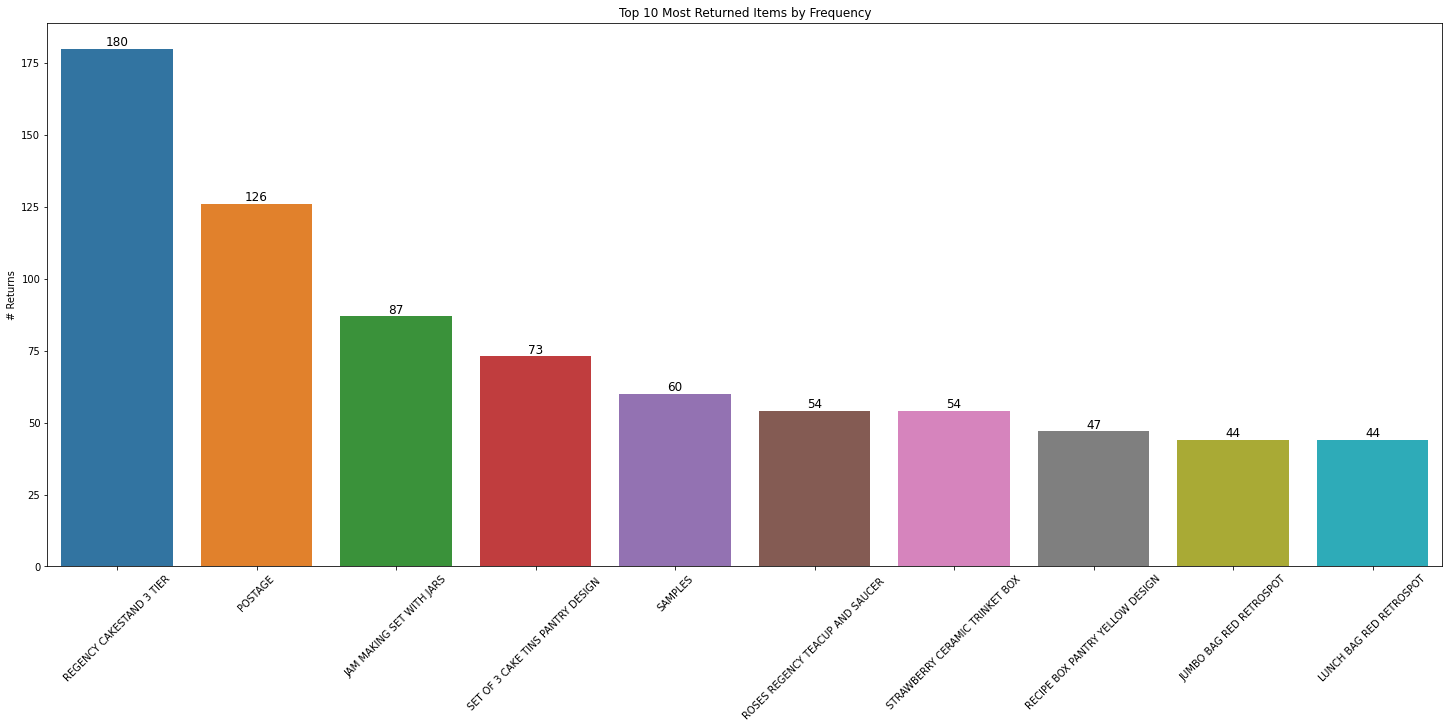

In [20]:
most_returned = neg_returns[~neg_returns["Description"].isin(["Manual", "Discount"])]["Description"].value_counts().nlargest(10)

plt.figure(figsize=(25, 10))
plt.title("Top 10 Most Returned Items by Frequency")
plt.ylabel("# Returns")
plt.xticks(rotation=45)
bars = sns.barplot(x=most_returned.index, y=most_returned.values)
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(bar.get_height()),
             ha='center', va='bottom', color='black', fontsize=12)

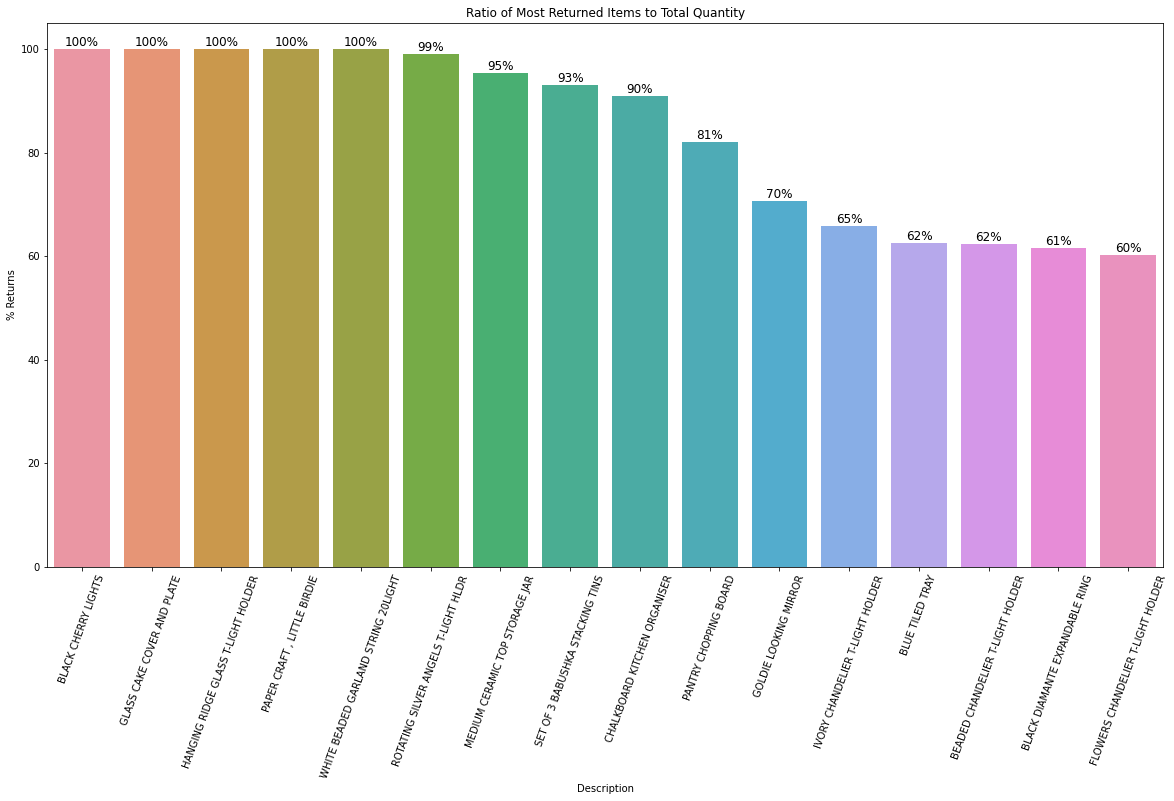

In [21]:
qs = pd.DataFrame({
    "ReturnedQuantity": clean_df.query('InvoiceNo.str.startswith("C")').groupby("Description")["Quantity"].apply(lambda qs: sum(-q for q in qs if q < 0)),
    "TotalQuantity": clean_df.groupby("Description")["Quantity"].apply(lambda qs: sum(q for q in qs if q > 0))
})
qs_ratio = qs.query("ReturnedQuantity > 0 and TotalQuantity > 0").copy()
qs_ratio["Ratio"] = qs_ratio["ReturnedQuantity"] / qs_ratio["TotalQuantity"] * 100
most_returned_pct = qs_ratio.query("60 <= Ratio <= 100")["Ratio"].sort_values(ascending=False)

plt.figure(figsize=(20, 10))
plt.title("Ratio of Most Returned Items to Total Quantity")
plt.ylabel("% Returns")
plt.xticks(rotation=70)
bars = sns.barplot(x=most_returned_pct.index, y=most_returned_pct.values)
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{int(bar.get_height())}%",
             ha='center', va='bottom', color='black', fontsize=12)

We can see that in terms of number of returns, the "REGENCY CAKESTAND 3 TIER" item is by far the most returned item (regardless of quantity), especially if we ignore "POSTAGE" returns. We also see that there are some items that their return rate is more than 60%, which indicates it might be a good idea to get rid of them, as their manufacturing quality is subpar.

Now that we've done that, let's do a final cleaning of our dataframe by removing all the returned items data:

In [22]:
returns = set()

def is_returned(row):
    # Taking care to check for the negative `Quantity`,
    # as these numbers are negative in the returns DF.
    return (row["StockCode"], -row["Quantity"], row["UnitPrice"], row["CustomerID"]) in returns

def get_non_returned_orders():
    """Return all non-returned orders. Takes a few seconds to run."""
    for _, row in neg_returns.iterrows():
        returns.add((row["StockCode"], row["Quantity"], row["UnitPrice"], row["CustomerID"]))
    s_returns = df.apply(is_returned, axis=1)
    return df[~s_returns].copy()

df = get_non_returned_orders()

Now we will take a look at how orders are distributed:

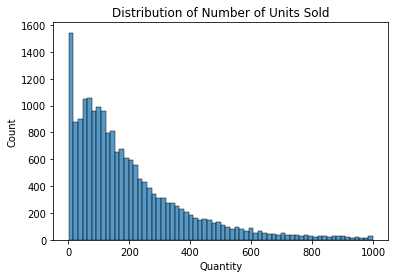

In [23]:
quantity_per_order = df.groupby("InvoiceNo")["Quantity"].sum()

sns.histplot(data=quantity_per_order[quantity_per_order <= 1000])
plt.title("Distribution of Number of Units Sold");

We can tell from this histogram that most of the orders are for relatively low quantities, with quantities in the hundreds (probably wholesale) being relatively rare.

Now let's look at the `StockCode` column:

In [24]:
print(f"We offer {df['StockCode'].nunique():,} unique items.")

We offer 3,916 unique items.


It's not *that* much, considering we have about half a million line items.

Let's do some popularity check, which items are hot, and which are not.

In [25]:
most_popular_stockcode = df["StockCode"].value_counts().index[0]

df[df["StockCode"] == most_popular_stockcode]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 09:02:00,2.55,17850.0
66,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 09:32:00,2.55,17850.0
220,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,2018-11-29 10:19:00,2.55,17511.0
262,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2018-11-29 10:39:00,2.55,13408.0
...,...,...,...,...,...,...,...
539342,581439,85123A,CREAM HANGING HEART T-LIGHT HOLDER,1,2019-12-06 16:30:00,5.79,NaN
539979,581452,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,2019-12-06 18:03:00,2.55,17675.0
540217,581472,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2019-12-06 19:55:00,2.95,15796.0
540837,581492,85123A,CREAM HANGING HEART T-LIGHT HOLDER,3,2019-12-07 10:03:00,5.79,NaN


In [26]:
df.loc[df["StockCode"] == most_popular_stockcode, "Quantity"].sum()

34932

People seem to love light holders, I guess, and they buy a lot of them at once. But the descriptions seem to be different among them, so let's make sure it makes sense:

In [27]:
df[df["StockCode"] == most_popular_stockcode]["Description"].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER',
       'CREAM HANGING HEART T-LIGHT HOLDER'], dtype=object)

Makes sense. Let's see if there's a seasonal trend:

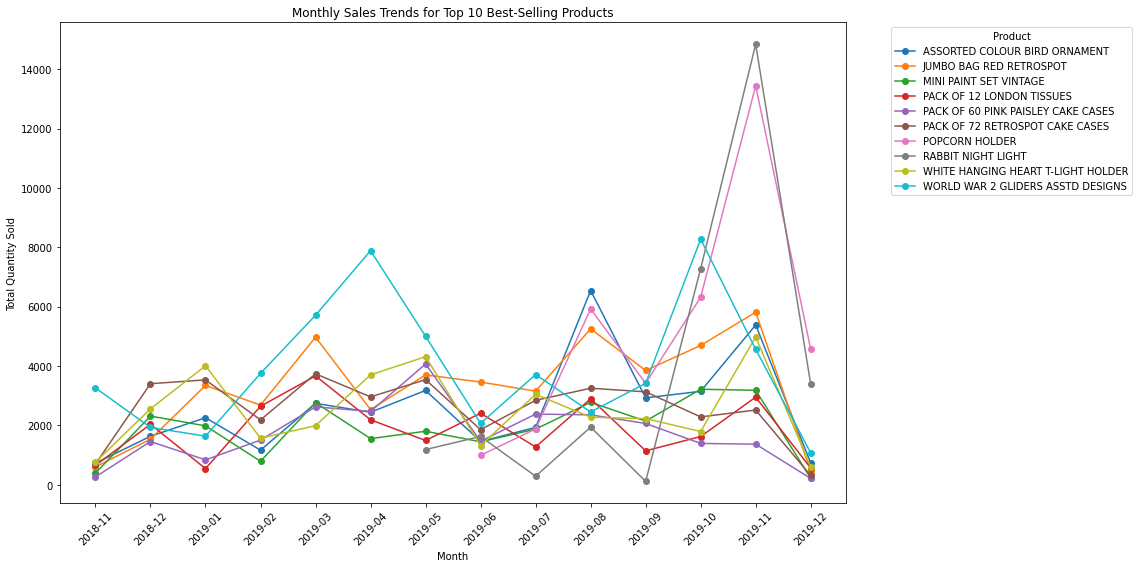

In [28]:
df["Month"] = df["InvoiceDate"].dt.to_period("M")

top_products = df.groupby('Description')['Quantity'].sum().nlargest(10)
top_products_data = df[df['Description'].isin(top_products.index)]
monthly_sales_top_products = top_products_data.groupby(['Month', 'Description'])['Quantity'].sum().unstack()

plt.figure(figsize=(16, 8))
for product in monthly_sales_top_products.columns:
    plt.plot(monthly_sales_top_products.index.astype(str), monthly_sales_top_products[product], marker='o', label=product)

plt.title('Monthly Sales Trends for Top 10 Best-Selling Products')
plt.xlabel('Month')
plt.ylabel('Total Quantity Sold')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout();

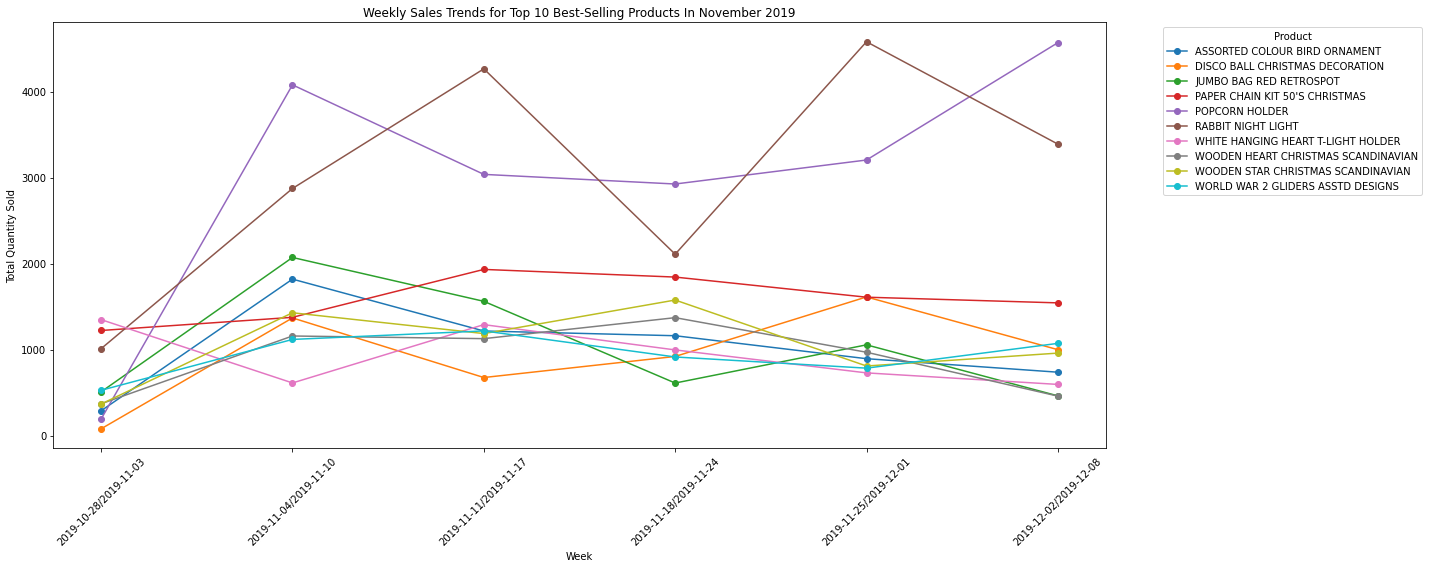

In [29]:
df["Week"] = df["InvoiceDate"].dt.to_period("W")

top_products = df.query('InvoiceDate >= "2019-11-01"').groupby('Description')['Quantity'].sum().nlargest(10)
top_products_data = df.query('InvoiceDate >= "2019-11-01" and Description.isin(@top_products.index)')
monthly_sales_top_products = top_products_data.groupby(['Week', 'Description'])['Quantity'].sum().unstack()

plt.figure(figsize=(20, 8))
for product in monthly_sales_top_products.columns:
    plt.plot(monthly_sales_top_products.index.astype(str), monthly_sales_top_products[product], marker='o', label=product)

plt.title('Weekly Sales Trends for Top 10 Best-Selling Products In November 2019')
plt.xlabel('Week')
plt.ylabel('Total Quantity Sold')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout();

We can see the following:

- Even though "WHITE HANGING HEART T-LIGHT HOLDER" is the most popular item *in general*, it seems to be doing only "fine" in contrast to the other 9 top items in terms of sales.
- The top 10 items are relatively stable in terms of sales, some appearing in the entire time frame of the dataset, and some, "RABBIT NIGHT LIGHT" and "POPCORN HOLDER", have peaked in the final week of November 2019, albeit only introduced in the middle of the year.

Let's look at the least popular items:

In [30]:
stockcode_counts = df["StockCode"].value_counts()
least_popular_stockcodes = stockcode_counts[stockcode_counts == stockcode_counts.min()].index.tolist()
print(f"There are {len(least_popular_stockcodes):,} items that were only purchased once.")

There are 154 items that were only purchased once.


But what are they?! Let's check 10 random ones, because 157 is too much to look at.

In [31]:
df[df["StockCode"].isin(least_popular_stockcodes)]["Description"].unique()[:10]

array(['GIRLY PINK TOOL SET', 'PINK MARSHMALLOW SCARF KNITTING KIT',
       'VINTAGE BLUE TINSEL REEL', 'WEEKEND BAG VINTAGE ROSE PAISLEY',
       'WRAP  PINK FLOCK', 'CHOCOLATE 1 WICK MORRIS BOX CANDLE',
       'OCEAN SCENT CANDLE JEWELLED DRAWER',
       'PINK BAROQUE FLOCK CANDLE HOLDER',
       'BEADED LOVE HEART JEWELLERY SET', 'PINK PAINTED KASHMIRI CHAIR'],
      dtype=object)

I really don't have anything to say about this assortment. I see a lot of pink, but for now, it doesn't mean anything.

Before we move on to testing hypotheses, we need something to lead us to the right things to test. Since this analysis goes to the higher-ups, and they care about those 💸💸💸, we'll take a look at number of sales and revenue in weekdays and weekends, as well as on a monthly basis with holiday months vs. the others.

In [32]:
# We want to group by days, but `InvoiceDate` includes time information as well.
df["DateOnly"] = pd.to_datetime(df["InvoiceDate"].dt.date)

df["DayOfWeek"] = df["InvoiceDate"].dt.dayofweek
df["MonthOfYear"] = df["InvoiceDate"].dt.month

df["Revenue"] = df["UnitPrice"] * df["Quantity"]

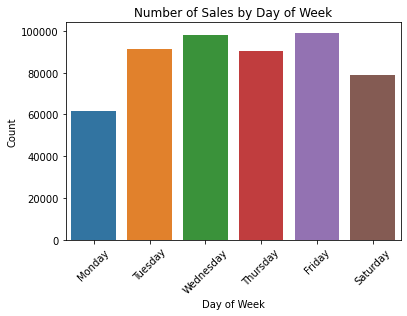

In [33]:
counts = df.groupby("DayOfWeek")["InvoiceNo"].count()
sns.barplot(x=counts.index, y=counts)
plt.xticks(range(6), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], rotation=45)
plt.title("Number of Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count");

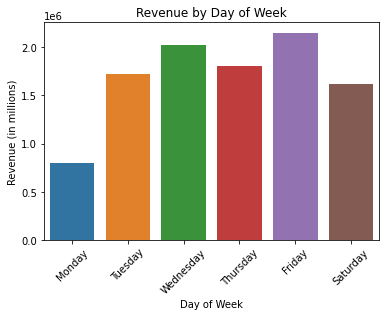

In [34]:
revenue = df.groupby("DayOfWeek")["Revenue"].sum()
sns.barplot(x=revenue.index, y=revenue)
plt.xticks(range(6), ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], rotation=45)
plt.title("Revenue by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Revenue (in millions)");

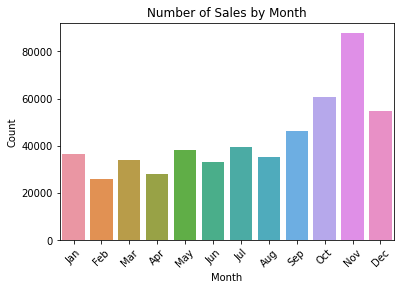

In [35]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
counts = df.groupby("MonthOfYear")["InvoiceNo"].count()
sns.barplot(x=counts.index, y=counts)
plt.xticks(range(12), months, rotation=45)
plt.title("Number of Sales by Month")
plt.xlabel("Month")
plt.ylabel("Count");

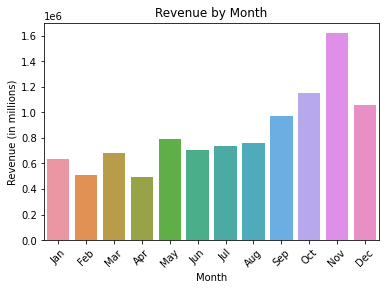

In [36]:
revenue = df.groupby("MonthOfYear")["Revenue"].sum()
sns.barplot(x=revenue.index, y=revenue)
plt.xticks(range(12), months, rotation=45)
plt.title("Revenue by Month")
plt.xlabel("Month")
plt.ylabel("Revenue (in millions)");

Moving on! We have a nice, clean dataframe to work with, so we carry out some experiments.

## Hypothesis Testing <a class="anchor" id="hypotheses">

We begin by deciding on a confidence level for our tests. As is tradition, we will go with $\alpha = 0.05$.

In [37]:
alpha = 0.05

### Test #1: Number of Sales - Weekdays vs. Weekends

- Null Hypothesis ($H_0$): There is no difference in daily number of sales between weekdays and weekends.
- Alternative Hypothesis ($H_1$): There is a significant difference in number of sales between weekdays and weekends.

In [38]:
weekdays_df = df.query('InvoiceDate.dt.dayofweek <= 4')
weekends_df = df.query('InvoiceDate.dt.dayofweek > 4')

weekdays_num_of_sales = weekdays_df.groupby("DateOnly")["InvoiceNo"].count()
weekends_num_of_sales = weekends_df.groupby("DateOnly")["InvoiceNo"].count()

result = st.ttest_ind(weekdays_num_of_sales, weekends_num_of_sales)

print(f"p-value = {result.pvalue}")

if result.pvalue < alpha:
    print("We reject the null hypothesis for Test #1")
else:
    print("We fail to reject the null hypothesis for Test #1")

p-value = 0.22145249448869023
We fail to reject the null hypothesis for Test #1


We see that there is no statistically significant difference between the daily number of sales on weekdays vs. weekends, customers buy "more or less" at the same volume.

### Test #2: Revenue - Weekdays vs. Weekends

- Null Hypothesis ($H_0$): There is no difference in revenue between weekdays and weekends.
- Alternative Hypothesis ($H_1$): There is a significant difference in revenue between weekdays and weekends.

In [39]:
weekdays_revenue = df.groupby("DateOnly")["Revenue"].sum()
weekends_revenue = df.groupby("DateOnly")["Revenue"].sum()

result = st.ttest_ind(weekdays_revenue, weekends_revenue)

print(f"p-value = {result.pvalue}")

if result.pvalue < alpha:
    print("We reject the null hypothesis for Test #2")
else:
    print("We fail to reject the null hypothesis for Test #2")

p-value = 1.0
We fail to reject the null hypothesis for Test #2


We see that in both tests, there is no statistically significant difference between weekdays and weekends. This could be due to the fact that we don't work on Sundays, thus "losing" an entire day's worth of sales. Judging by the descriptions and quantities we saw during our exploration, we might be more of a wholesaler rather than a retail store, and our customers work during weekdays only.

### Test #3: Number of Sales - Holiday Months vs. Other Months

- Null Hypothesis ($H_0$): There is no difference in number of sales between Nov-Dec and the other months.
- Alternative Hypothesis ($H_1$): Holiday months generate more sales than other months.

In [40]:
holidays_df = df.query('InvoiceDate.dt.month >= 11')
others_df = df.query('InvoiceDate.dt.month < 11')

holiday_months_sales = holidays_df.groupby("DateOnly")["InvoiceNo"].count()
other_months_sales = others_df.groupby("DateOnly")["InvoiceNo"].count()

result = st.ttest_ind(holiday_months_sales, other_months_sales, alternative="greater")

print(f"p-value = {result.pvalue}")

if result.pvalue < alpha:
    print("We reject the null hypothesis for Test #3")
else:
    print("We fail to reject the null hypothesis for Test #3")

p-value = 6.764116296866241e-30
We reject the null hypothesis for Test #3


Awesome, this means that the number of sales in holiday months is significantly higher than in other months. Let's check revenue:

### Test #4: Revenue - Holiday Months vs. Other Months

- Null Hypothesis ($H_0$): There is no difference in revenue between Nov-Dec and the other months.
- Alternative Hypothesis ($H_1$): Holiday months generate more revenue than other months.

In [41]:
holiday_months_revenue = holidays_df.groupby("DateOnly")["Revenue"].sum()
other_months_revenue = others_df.groupby("DateOnly")["Revenue"].sum()

result = st.ttest_ind(holiday_months_revenue, other_months_revenue, alternative="greater")

print(f"p-value = {result.pvalue}")

if result.pvalue < alpha:
    print("We reject the null hypothesis for Test #4")
else:
    print("We fail to reject the null hypothesis for Test #4")

p-value = 4.749972364693708e-18
We reject the null hypothesis for Test #4


With the results of this test, we can tell our stakeholders that the Thanksgiving/Christmas months are prime land for more marketing, as both the number of sales and revenue in those months is significantly higher than in other months.

### Test #5: Revenue on Mondays vs. the Rest of the Week

- Null Hypothesis ($H_0$): Revenue on Mondays is the same, on average, to the other days of the week.
- Alternative Hypothesis ($H_1$): Revenue on Mondays is significantly lower than other days of the week.

In [42]:
mondays_revenue = df.query('DayOfWeek == 0').groupby("DateOnly")["Revenue"].sum()
other_days_revenue = df.query('DayOfWeek != 0').groupby("DateOnly")["Revenue"].sum()

result = st.ttest_ind(mondays_revenue, other_days_revenue, alternative="less")

print(f"p-value = {result.pvalue}")

if result.pvalue < alpha:
    print("We reject the null hypothesis for Test #5")
else:
    print("We fail to reject the null hypothesis for Test #5")

p-value = 3.0729174128866116e-15
We reject the null hypothesis for Test #5


We have statistically shown that Monday is not a good day for business, apparently. 🤷‍♂️

## Conclusion <a class="anchor" id="conclusion">

Our analysis has come to an end, so let's talk about what we learned and what we can do about it.

- We have no sales data on Sundays at all, and Mondays are doing significantly worse sales-wise than other days of the week. As Monday is a work day, we should perhaps target our audience with promotions on this specific day ("Monday Funday" or something).
- Although perhaps unsurprising, there are significantly more sales and more revenue on Nov-Dec than in the other months. Our data shows that November is a big month, and not necessarily due to Black Friday. However, since it appears our store targets businesses and not individuals, it could be that businesses buy their employees' Christmas gifts early, so that it will arrive by Christmas. This means that we need to do something about the rest of the year, such as promotions and targeted ads. Valentine's Day 😍, St. Patrick's Day 🍀, whatever the occasion is, we should capitalize on it!
- There are some items that are returned very frequently, both in absolute number of returns per product and in percentage of the total quantity sold. Higher-ups should look at those items and see if they need to be removed from the shelves, or improved somehow.
- In the past year we had ~9,200 order returns, totaling a loss of a bit less than \\$900,000. That's no laughing matter given that our yearly revenue (excluding those returns) is around \\$10M. It is imperative to understand the reasons behind the returns and employ mitigation steps.
- We've seen that some items are best-sellers because they do well in a stable manner the entire year, and there are some best-sellers who just did *really* well in November 2019 which spiked their "importance". It's worth checking the types of products in both of these categories, and expand our assortment for each; and, of course, adjust marketing for seasonal products.